In [26]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [27]:
# all the files have a average_relative_error column, use that to filter for kernels with non-determinism
nd_kernel_files = []
key = 'unique_outputs'
threshold = 1
csv_dir = 'data'
#ipynb files getting added....
data_files = [file for file in os.listdir(csv_dir) if file.split('.')[1]=='csv']
for file in data_files:
    data = pd.read_csv(os.path.join(csv_dir,file))
    if key not in data.keys():
        print("Warning: {} has no relative error data...".format(file))
    if data[key].gt(threshold).any():
        nd_kernel_files.append(file)
nd_kernel_files.sort()

In [28]:
print("Non-deterministic kernels found:")
for k in nd_kernel_files:
    print("  {}".format(k.split('.csv')[0]))

Non-deterministic kernels found:
  ConvTranspose1d
  ConvTranspose2d
  ConvTranspose3d
  cumsum
  index_add
  index_copy
  index_put
  kthvalue
  median
  scatter
  scatter_reduce


In [29]:
for file in nd_kernel_files:
    data = pd.read_csv(os.path.join(csv_dir,file))
    print(data['unique_outputs'].unique())

[1 2]
[1 2]
[1 2]
[   1 1001]
[   2    9    3   99   14   10 1001]
[   1    3    2    4 1001]
[ 1  2 56  3  5]
[2 1]
[   2 1001]
[  52  417  847  938  944 1001  998]
[ 185   49  253   75  676  171  832  160 1000  230  476  992  563 1001
  733  380  739  418  779  996  965  995  970  977    1    2    3    7
    5    4]


## Prelim: Some statistics

Comments:
* Changing the hyperparameter changes the ground truth value $A$.

There's a tensor $A$ from a deterministic kernel, and kernel $B$ from a nondeterministic kernel.

#### Average of Averages is Bad

In [30]:
true_value = 1.1
data1 = np.array([1.11,1.24,1.07])
data2 = np.array([1.3,1.2,1.25])
data3 = np.array([0.8,1.4,1.3,0.95,0.7,1.5])
alldata = np.concatenate((data1,data2,data3))

print("Using all data: {:.2} +/- {:.2}".format(np.mean(alldata), np.std(alldata)))

mean_mean = (np.mean(data1)+np.mean(data2)+np.mean(data3))/3.0
std_mean = np.sqrt(np.std(data1)**2 + np.std(data2)**2 + np.std(data3)**2)

print("Average of averages: {:.2} +/- {:.2}".format(mean_mean, std_mean))


Using all data: 1.2 +/- 0.23
Average of averages: 1.2 +/- 0.32


#### Uncertainties & Error

In [35]:
true_value = 9.8
measured_values = np.array([9.7,9.82,9.9,9.84,9.86,9.84,9.77,9.87])

print("measured value = {:.4} +/- {:.4}".format(np.mean(measured_values), np.std(measured_values)))

measured value = 9.825 +/- 0.05916


In [39]:
print("Using uncertainty directly to compute abs/rel error")
print("  Absolute error = {:.4} +/- {:.4}".format(np.abs(np.mean(measured_values)-true_value), np.std(measured_values)))
print("  Relative error = {:.4} +/- {:.4}".format(np.abs(np.mean(measured_values)-true_value)/true_value, np.std(measured_values)/true_value))

Using uncertainty directly to compute abs/rel error
  Absolute error = 0.025 +/- 0.05916
  Relative error = 0.002551 +/- 0.006037


In [40]:
print("Using measurements of abs & relative error")
abs_error_measurements = np.abs(measured_values - true_value)
rel_error_measurements = np.abs(measured_values - true_value)/true_value

print("  Absolute error = {:.4} +/- {:.4}".format(np.mean(abs_error_measurements), np.std(abs_error_measurements)))
print("  Relative error = {:.4} +/- {:.4}".format(np.mean(rel_error_measurements), np.std(rel_error_measurements)))  

Using measurements of abs & relative error
  Absolute error = 0.0575 +/- 0.02861
  Relative error = 0.005867 +/- 0.00292


These *mean* different things!

## Prelim: Floating point precision

[Kahan summation](https://en.wikipedia.org/wiki/Kahan_summation_algorithm)

In [20]:
print("{:.6}".format(10000.0 + 3.14159 + 2.71828))

10005.9


In [22]:
from decimal import *
getcontext().prec=6
total:float = Decimal(10000.0)
y:float = Decimal(3.14159)
z:float = Decimal(2.71828)

In [23]:
print("{} is wrong!".format(total+y+z))

10005.8 is wrong!


In [24]:
# with Kahan summation

In [25]:
t = total + y
c = (t - total) - y
total = t

y = z - c
t = total + y
c = (t - total) - y

print(t)

10005.9


## Distribution of Errors

Not entirely sure of meaning, since these are histograms of average errors.  Just wanted to see magnitudes of errors, how often they are much larger than floating point precision $\approx 10^{-7}$.  

Convolutions and cumulative summation seem to be the biggest culprits.

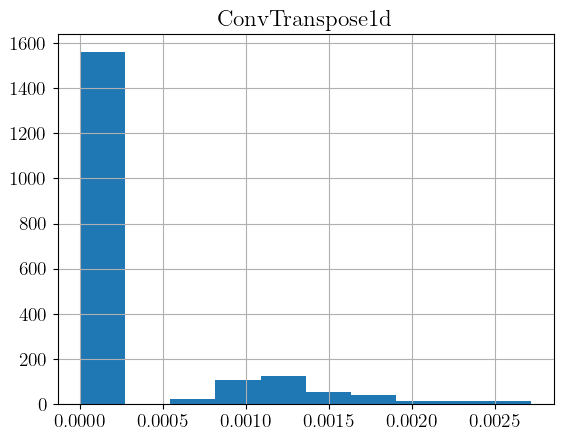

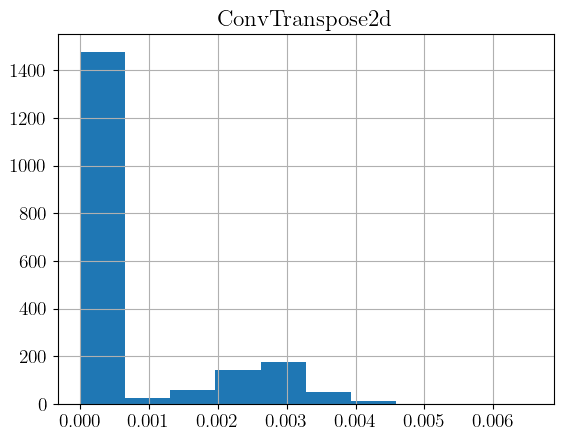

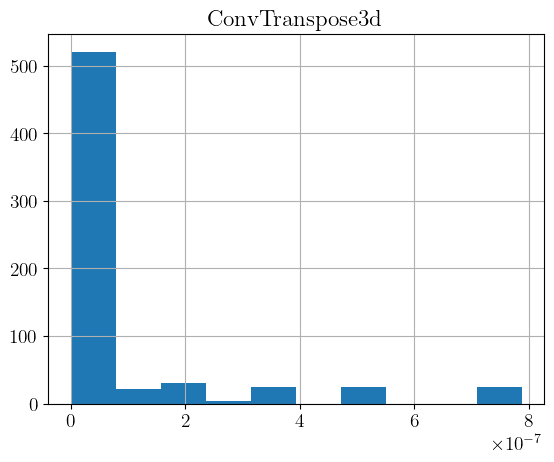

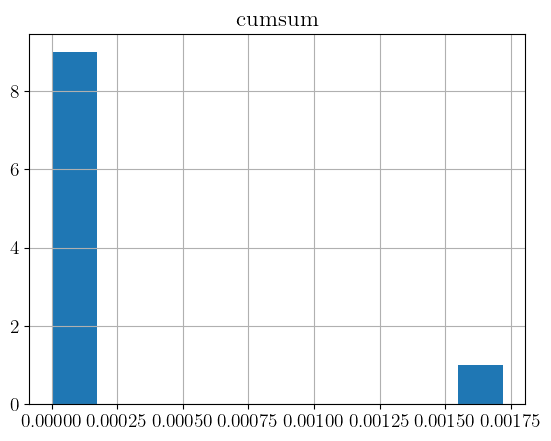

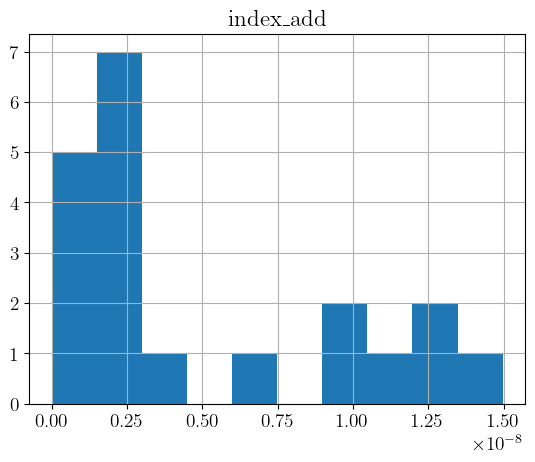

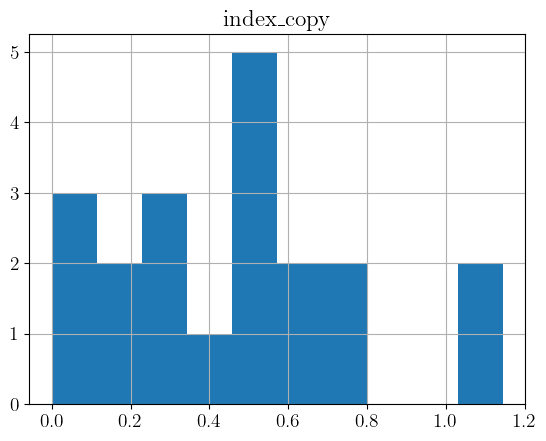

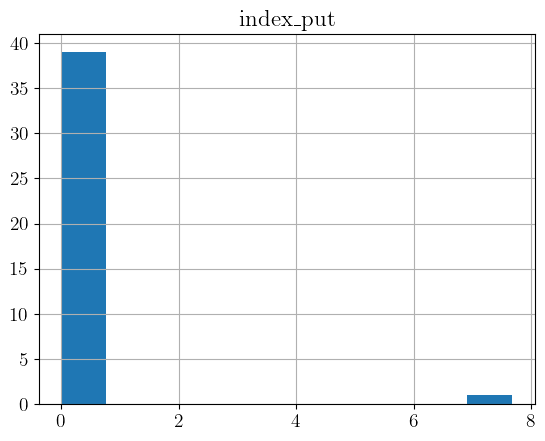

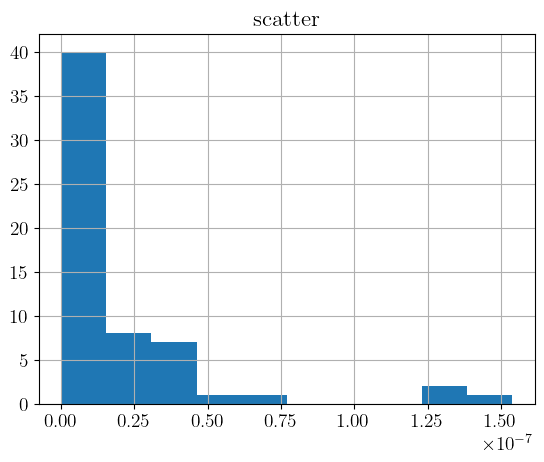

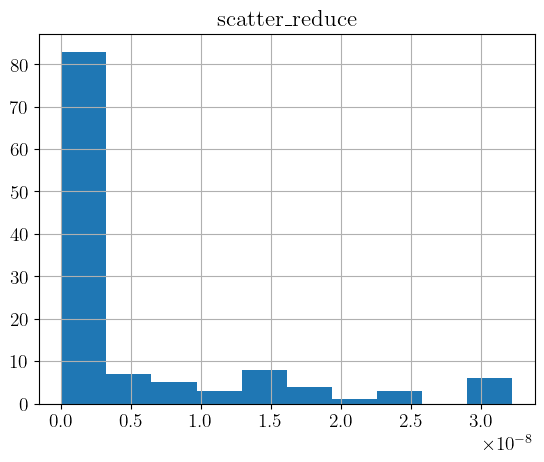

In [17]:
for file in nd_kernel_files:
    data = pd.read_csv(os.path.join(csv_dir, file))
    data.hist(column='average_relative_error')
    plt.title(file.split('.csv')[0])
    plt.ticklabel_format(axis='both', style='sci')
    plt.show()

## Non-deterministic has errors

In [6]:
black = '\x1b[0m'
green = '\x1b[32m'
red = '\x1b[31m'

In [7]:
threshold=0.0

print(green + "deterministic " + red + "non-deterministic")  
for file in nd_kernel_files:
    data = pd.read_csv(os.path.join(csv_dir,file))
    ndfilter=data['average_relative_error'].gt(threshold)
    print(black + '----{}----'.format(file.split('.csv')[0]))
    for key in data.keys():
        if key not in ["average_relative_error", "average_runtime"]:
            values_tried = data[key].unique()
            nd_values = data[ndfilter][key].unique()
            s = black + key + "  "
            for value in values_tried:
                if value in nd_values:
                    s+=red+str(value)
                else:
                    s+=green+str(value)
                s+="  "
            print(s)
print()

deterministic non-deterministic
----ConvTranspose1d----
batch_size  1  2  
dim  (3, 256)  (3, 512)  (3, 1024)  
dtype  torch.float32  
kernel_size  (3,)  (5,)  (7,)  
stride  1  3  5  
padding  0  1  
dilation  1  2  5  
group  1  2  3  
reduction_ratio  nan  
unique_outputs  1  2  
unique_outputs_per_iteration  0.5  1.0  
----ConvTranspose2d----
batch_size  1  2  
dim  (3, 256, 256)  (3, 512, 512)  (3, 1024, 1024)  
dtype  torch.float32  
kernel_size  (3, 3)  (5, 5)  (7, 7)  
stride  1  3  5  
padding  0  1  
dilation  1  2  5  
group  1  2  3  
reduction_ratio  nan  
unique_outputs  1  2  
unique_outputs_per_iteration  0.5  1.0  
----ConvTranspose3d----
batch_size  1  2  
dim  (3, 64, 64, 64)  
dtype  torch.float32  
kernel_size  (3, 3, 3)  (5, 5, 5)  (7, 7, 7)  
stride  1  3  5  
padding  0  1  
dilation  1  2  5  
group  1  2  3  
reduction_ratio  nan  
unique_outputs  1  2  
unique_outputs_per_iteration  0.5  1.0  
----cumsum----
input_dimensions  nan  
dim  0  1  
dtype  torch.fl

In [9]:
threshold=np.finfo(np.float32).eps
print("threshold = {}".format(threshold))
print(green + "deterministic " + red + "non-deterministic")  
for file in nd_kernel_files:
    data = pd.read_csv(os.path.join(csv_dir,file))
    ndfilter=data['average_relative_error'].gt(threshold)
    print(black + '----{}----'.format(file.split('.csv')[0]))
    for key in data.keys():
        if key not in ["average_relative_error", "average_runtime"]:
            values_tried = data[key].unique()
            nd_values = data[ndfilter][key].unique()
            s = black + key + "  "
            for value in values_tried:
                if value in nd_values:
                    s+=red+str(value)
                else:
                    s+=green+str(value)
                s+="  "
            print(s)
print()

threshold = 1.1920928955078125e-07
deterministic non-deterministic
----ConvTranspose1d----
batch_size  1  2  
dim  (3, 256)  (3, 512)  (3, 1024)  
dtype  torch.float32  
kernel_size  (3,)  (5,)  (7,)  
stride  1  3  5  
padding  0  1  
dilation  1  2  5  
group  1  2  3  
reduction_ratio  nan  
unique_outputs  1  2  
unique_outputs_per_iteration  0.5  1.0  
----ConvTranspose2d----
batch_size  1  2  
dim  (3, 256, 256)  (3, 512, 512)  (3, 1024, 1024)  
dtype  torch.float32  
kernel_size  (3, 3)  (5, 5)  (7, 7)  
stride  1  3  5  
padding  0  1  
dilation  1  2  5  
group  1  2  3  
reduction_ratio  nan  
unique_outputs  1  2  
unique_outputs_per_iteration  0.5  1.0  
----ConvTranspose3d----
batch_size  1  2  
dim  (3, 64, 64, 64)  
dtype  torch.float32  
kernel_size  (3, 3, 3)  (5, 5, 5)  (7, 7, 7)  
stride  1  3  5  
padding  0  1  
dilation  1  2  5  
group  1  2  3  
reduction_ratio  nan  
unique_outputs  1  2  
unique_outputs_per_iteration  0.5  1.0  
----cumsum----
input_dimensions

## Heatmaps

In [30]:
def make_heatmaps(filtered_data, axis_keys):
    plt.rcParams['text.usetex'] = True
    font = {'family' : 'normal',
            'size'   : 8}
    
    matplotlib.rc('font', **font)
    fig, axs = plt.subplots(len(axis_keys), len(axis_keys)-1)
    fig.set_figwidth(14)
    fig.set_figheight(14)
    for i in range(len(axis_keys)):
        for j in range(len(axis_keys)):
            if j>i:
                square_df = filtered_data[[axis_keys[i],axis_keys[j],"unique_outputs"]].pivot_table(index=axis_keys[i],columns=axis_keys[j],values='unique_outputs')
                sns.heatmap(square_df, ax=axs[i,j-1])
            if j!=(i+1):
                axs[i,j-1].set(xlabel=None)
                axs[i,j-1].set(ylabel=None)
            if j<i:
                axs[i,j].axis('off')
    return plt

In [31]:
def get_filtered_data(filename, value_key, threshold):
    data = pd.read_csv(filename)
    data = data.dropna(axis='columns')
    ndfilter = data[value_key].gt(threshold)
    return data[ndfilter]

In [32]:
common_keys = ['average_runtime', 'average_relative_error', 'unique_outputs', 'unique_outputs_per_iteration']
def heatmap_grid(filename):
    data = get_filtered_data(filename,  'unique_outputs', 1)
    plotting_keys = [key for key in data.keys() if key not in common_keys]
    plt = make_heatmaps(data, plotting_keys)
    return plt

------------------ ConvTranspose1d ------------------


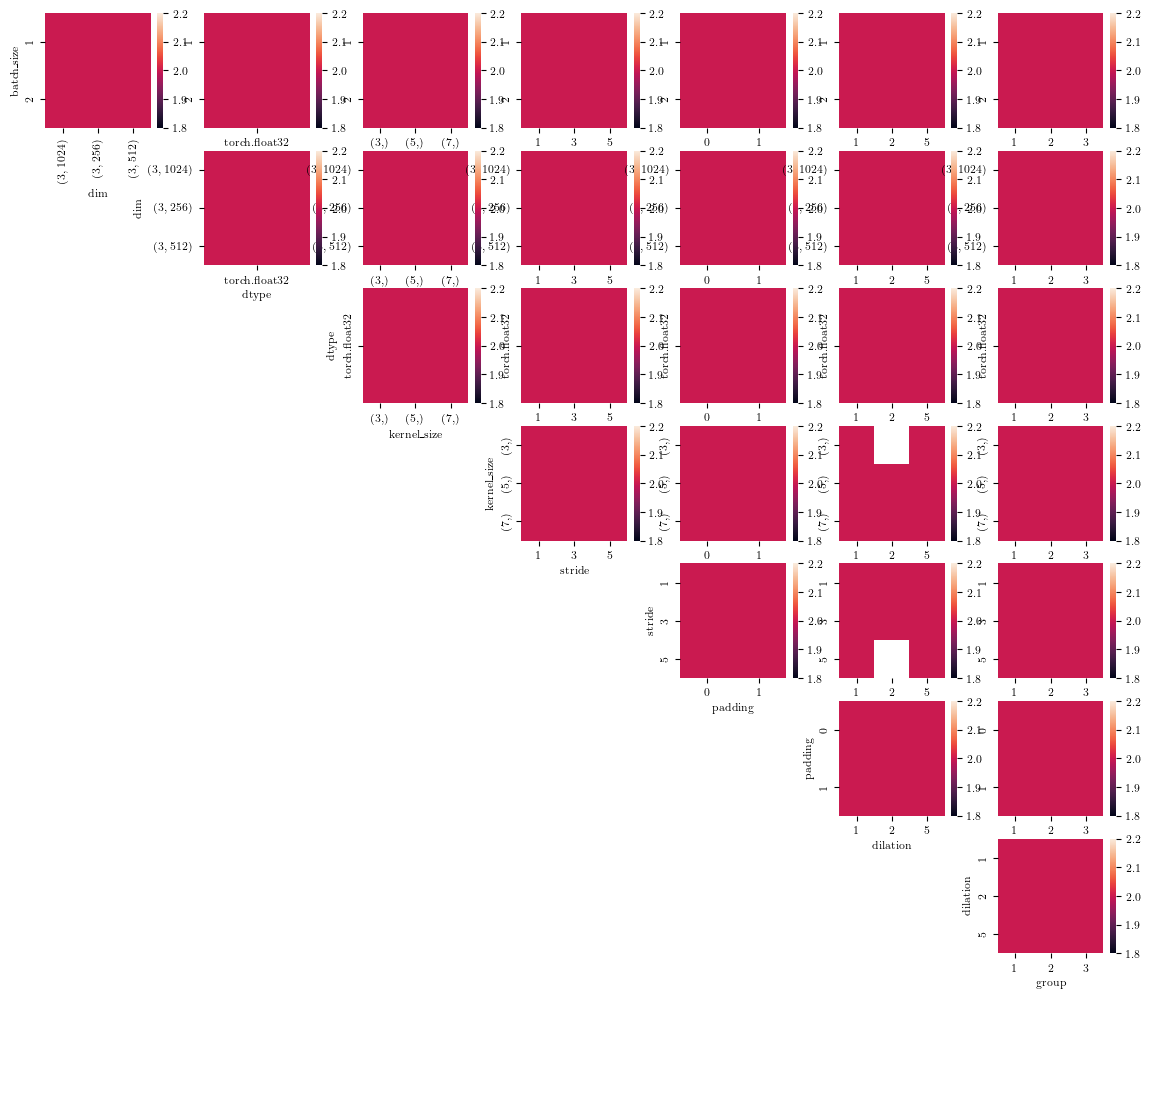


------------------ ConvTranspose2d ------------------


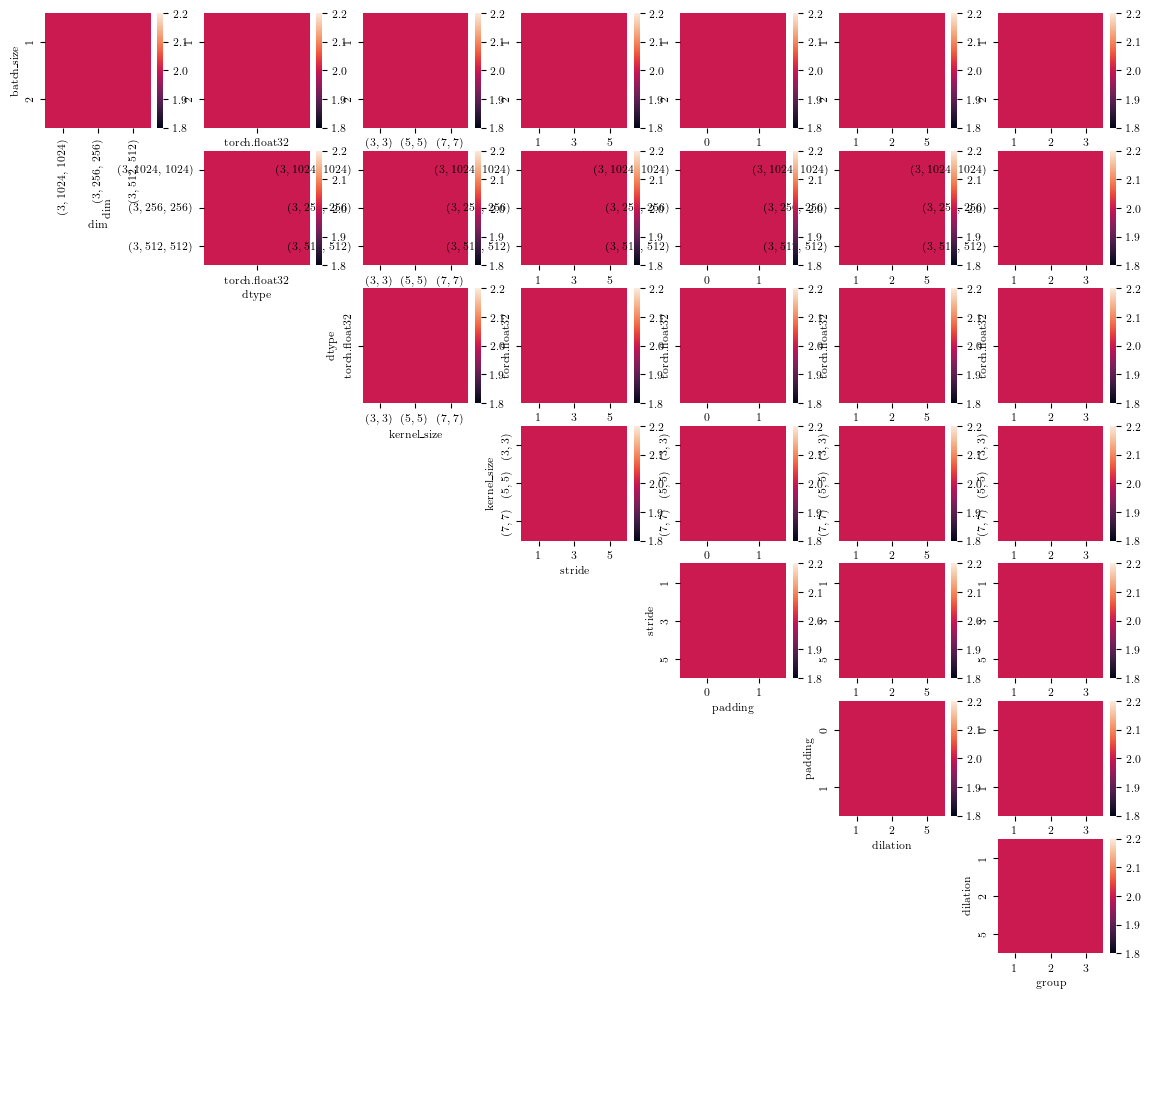


------------------ ConvTranspose3d ------------------


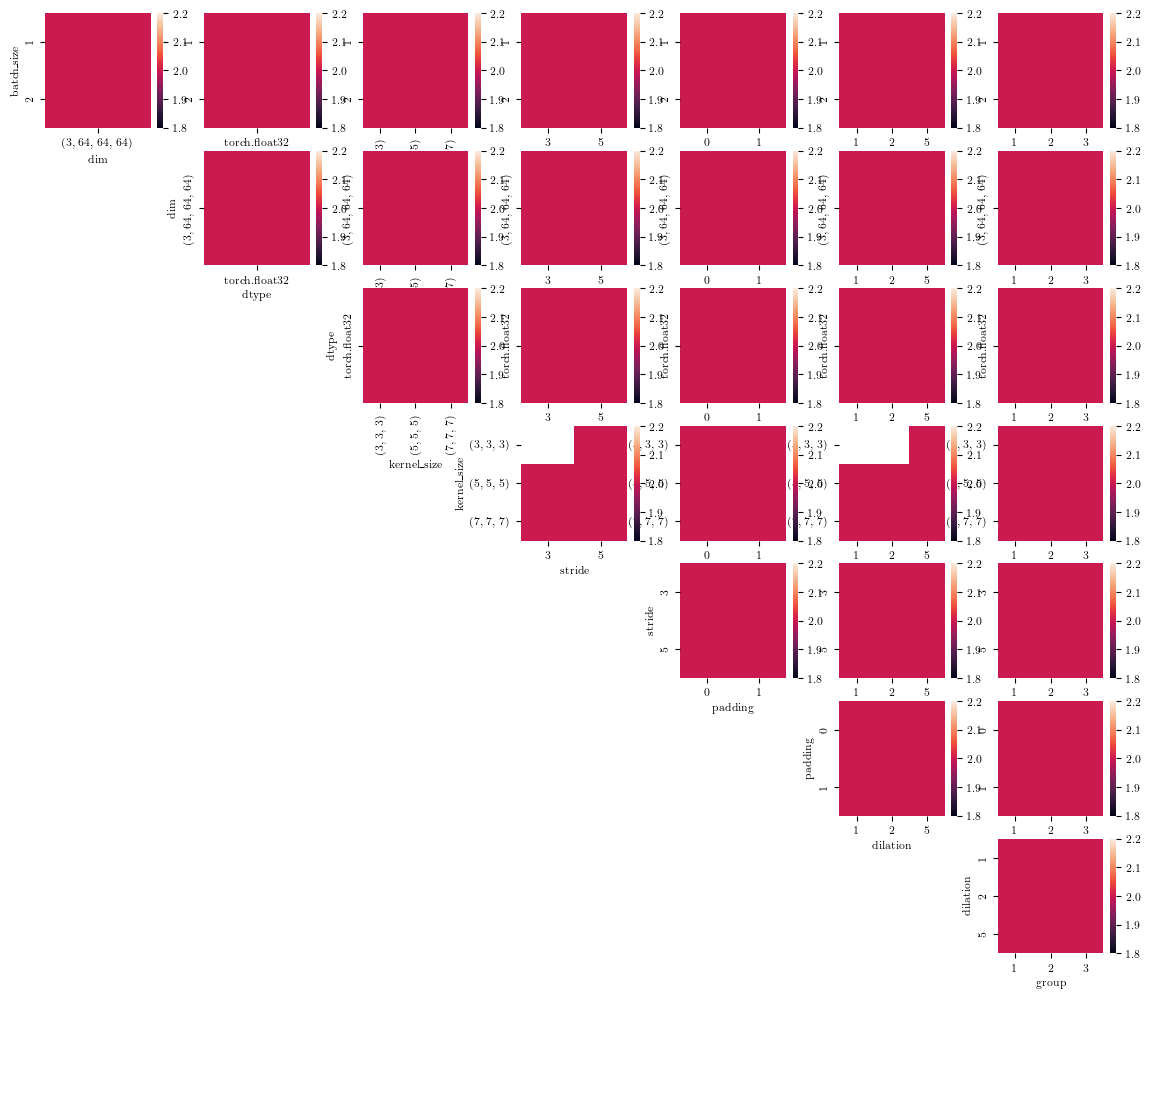


------------------ cumsum ------------------


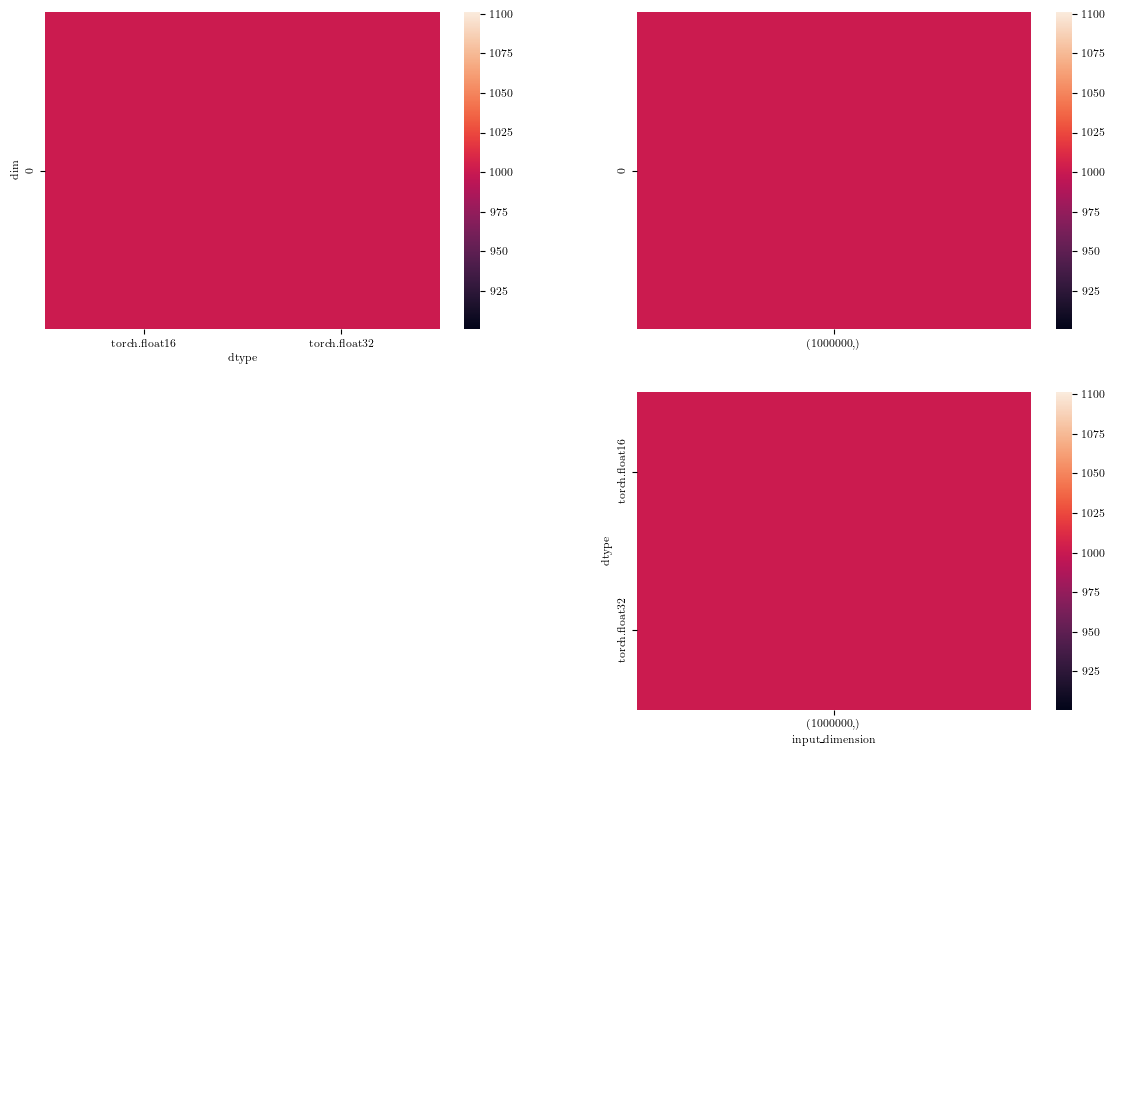


------------------ index_add ------------------


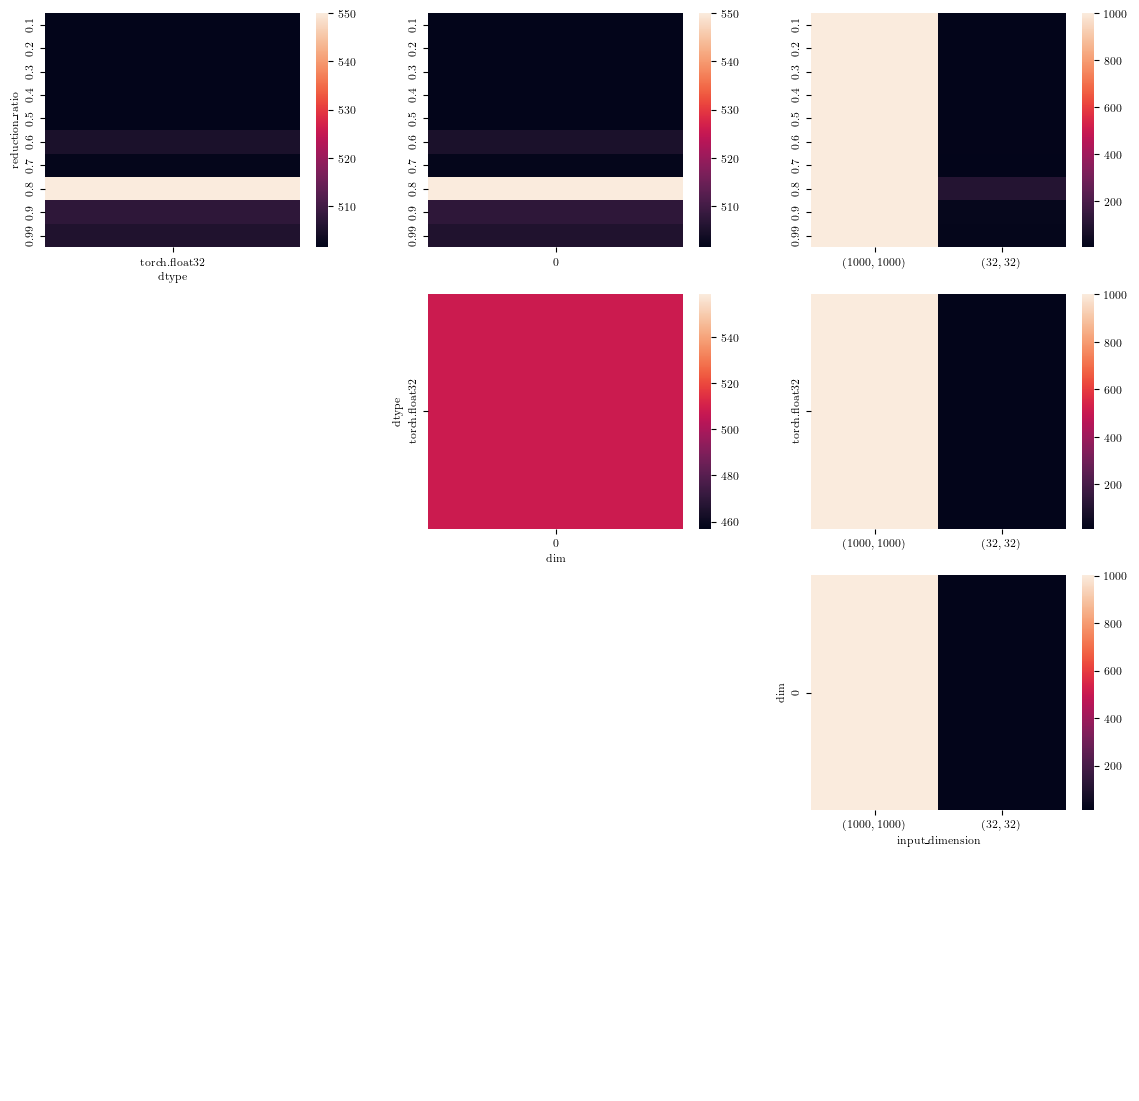


------------------ index_copy ------------------


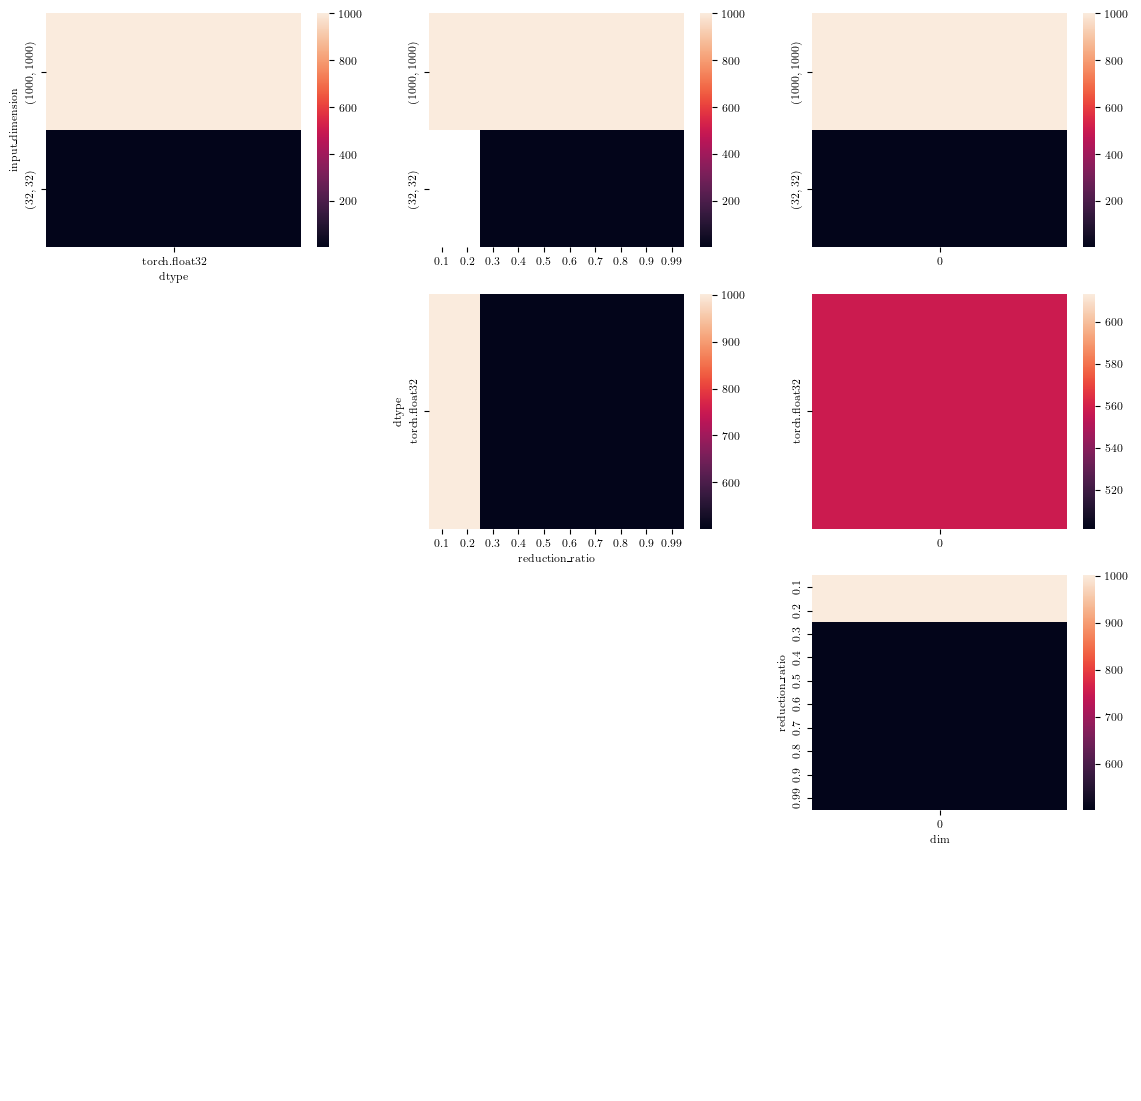


------------------ index_put ------------------


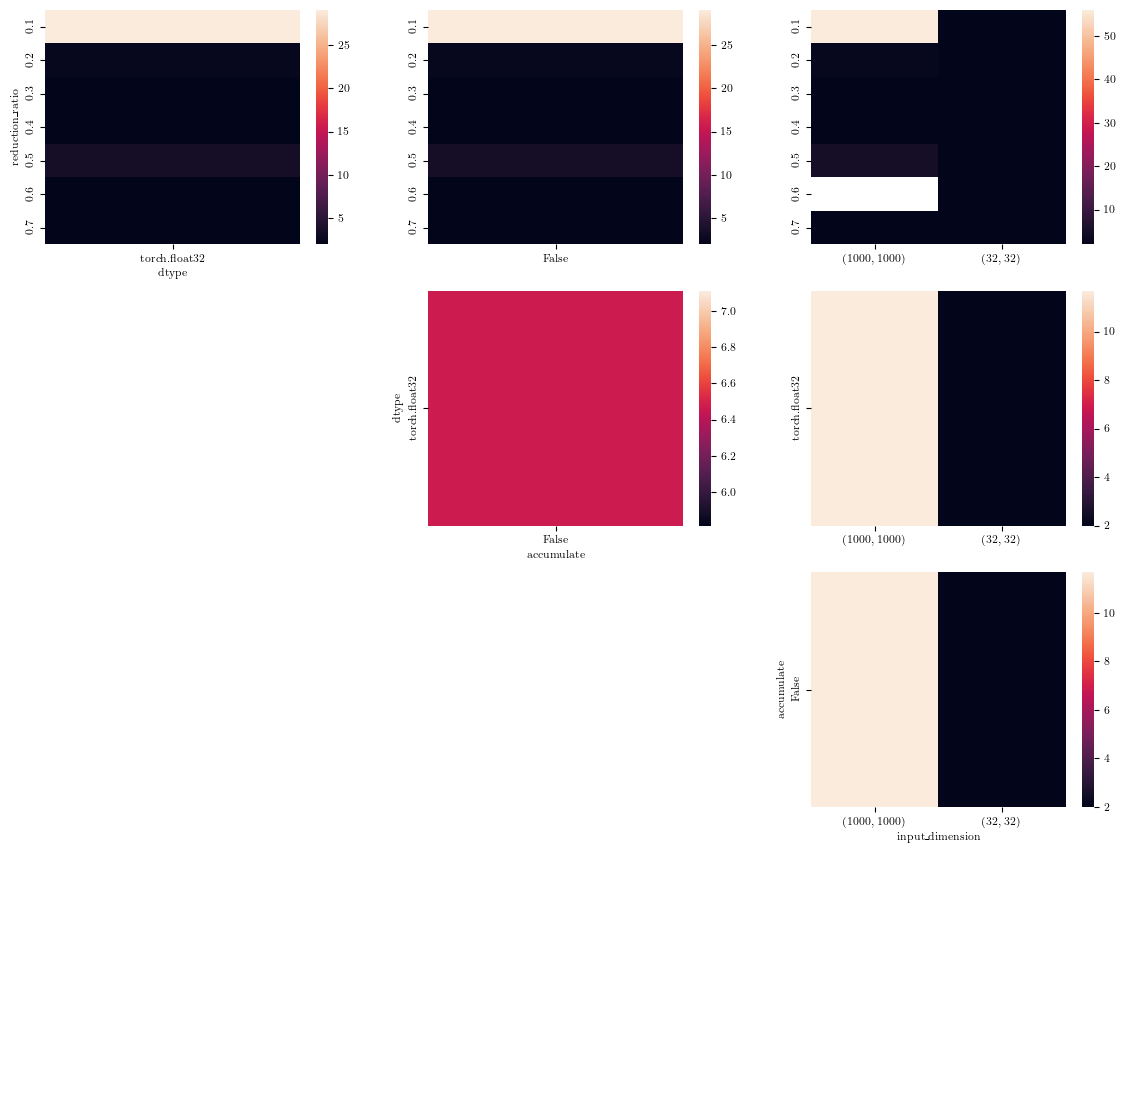


------------------ kthvalue ------------------


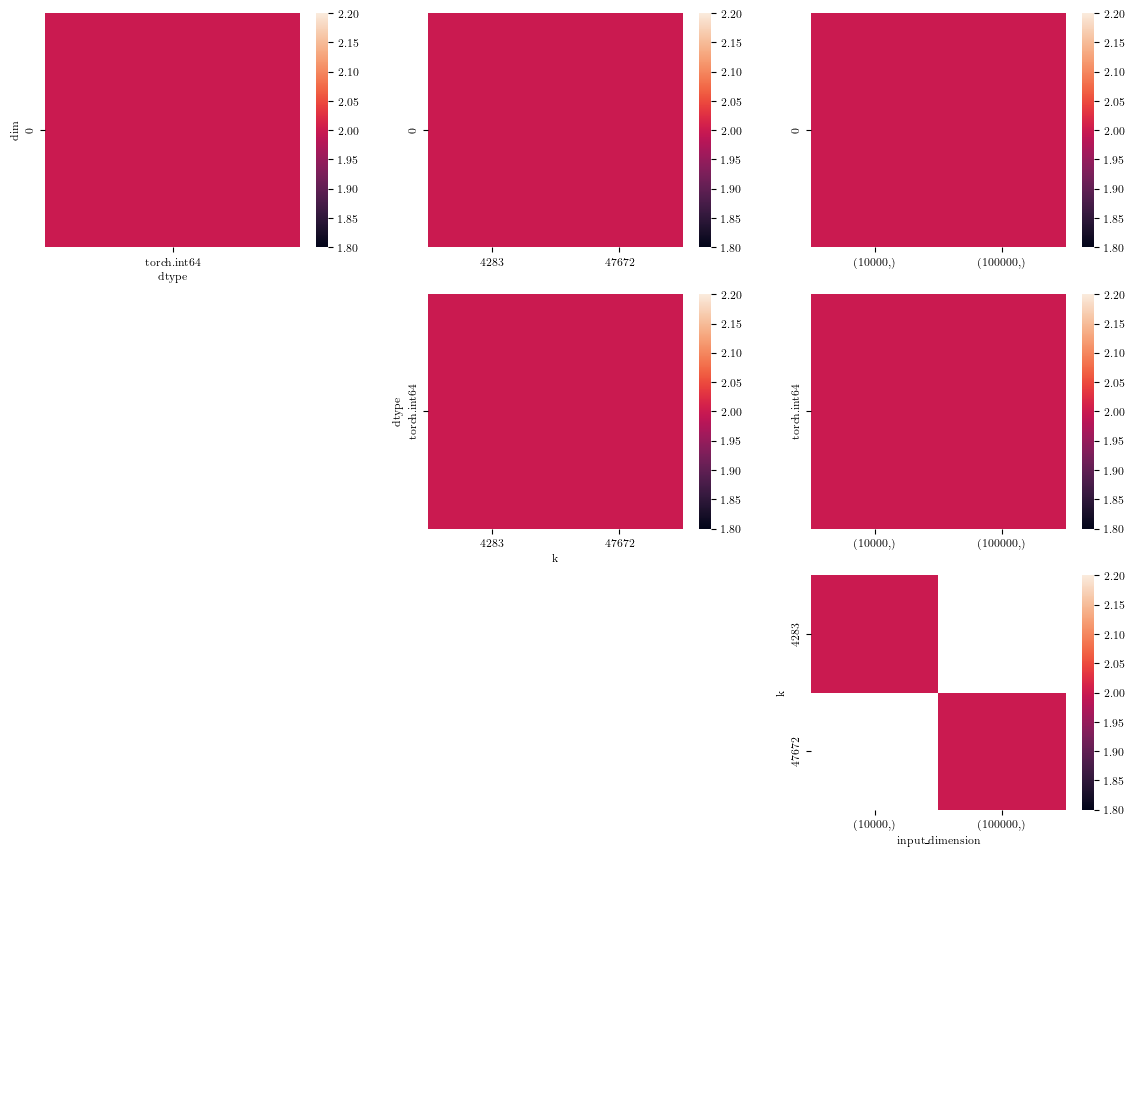


------------------ median ------------------


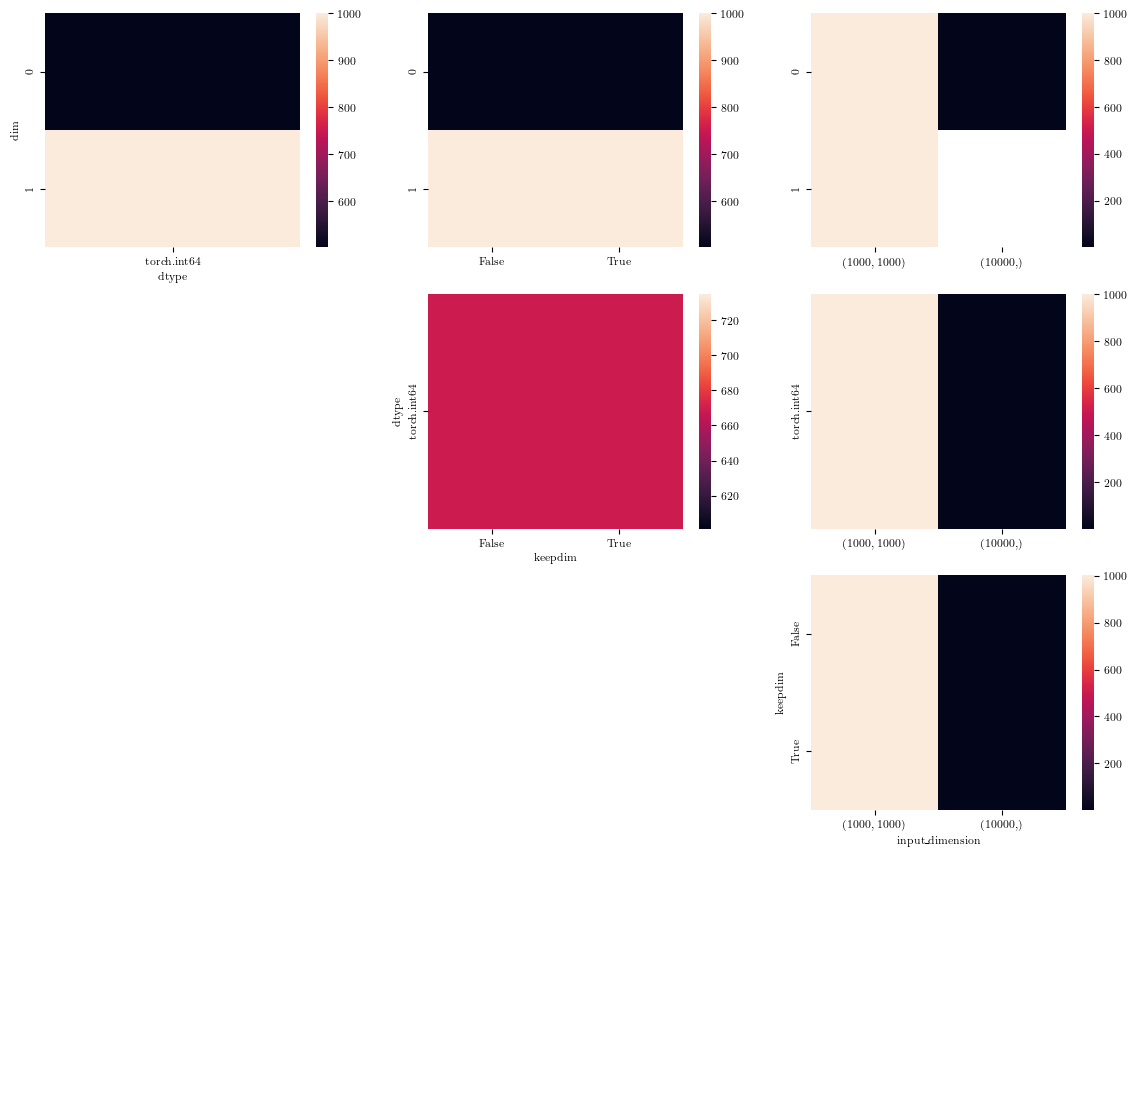


------------------ scatter ------------------


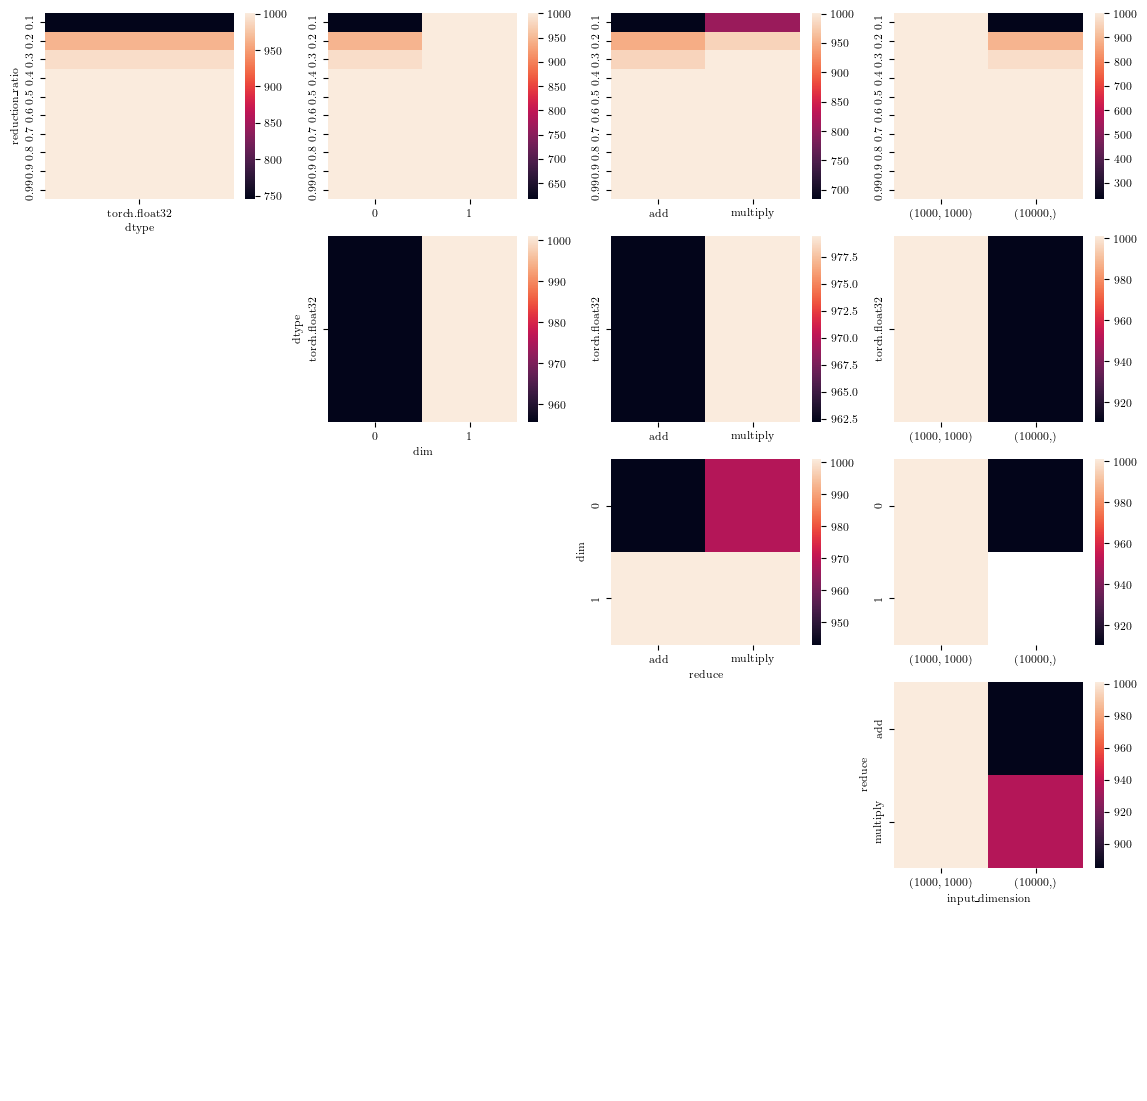


------------------ scatter_reduce ------------------


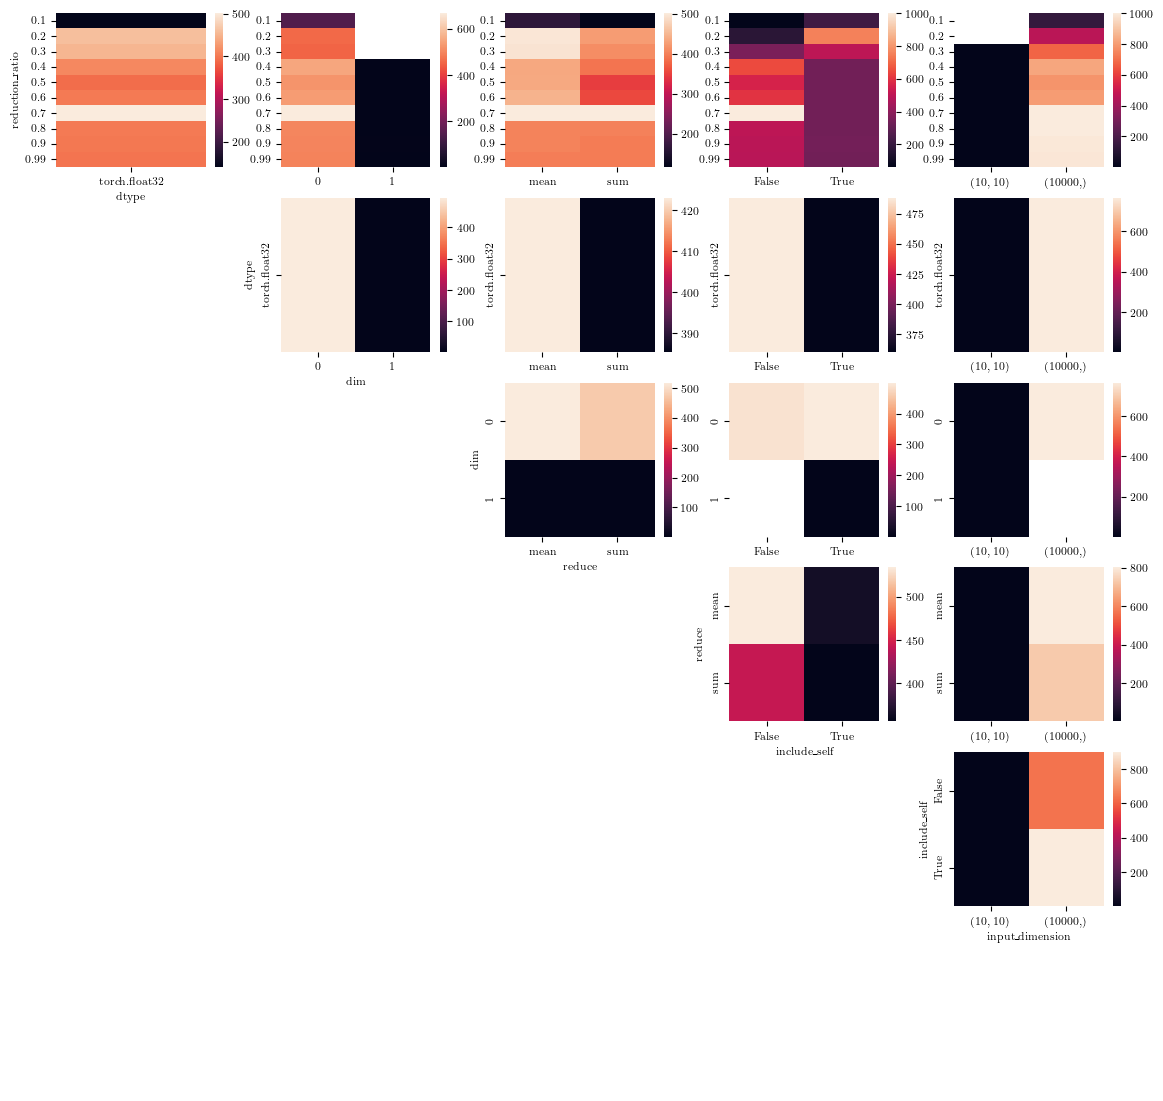

In [33]:
for file in nd_kernel_files:
    print("------------------ {} ------------------".format(file.split('.csv')[0]))
    plt = heatmap_grid(os.path.join('data',file))
    plt.show()
    print()